## Предсказание оттока пользователей (весна 2021)
https://www.kaggle.com/c/advanced-dls-spring-2021/

Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS (весна 2021)

Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

На станице с данными вы можете загрузить два файла - train.csv (содержит колонки признаков и целевую переменную) и test.csv (содержит только колонки признаков).

В качестве ответа вам необходимо загрузить предсказания вероятностей ухода клиентов для test.csv. Пример файла с предскзааниями - submission.csv.

Названия признаков и целевой пременной есть в baseline ноутбуке. (baseline - базовое решение, с которым обычно сравниают более продвинутые алгоритмы.)


В данном соревновании решения будут сравниваться по метрике ROC-AUC. Для получения полного балла за соревнование не достаточно получить высокое значение метрики, подробные критерии есть в baseline ноутбуке и на stepik.

### Загрузка данных

In [2]:
!kaggle competitions download -c advanced-dls-spring-2021

  0%|                                                | 0.00/115k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 115k/115k [00:00<00:00, 1.71MB/s]


In [3]:
!unzip advanced-dls-spring-2021.zip -d data

Archive:  advanced-dls-spring-2021.zip
  inflating: data/submission.csv     
  inflating: data/test.csv           
  inflating: data/train.csv          


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import optuna
from optuna.samplers import RandomSampler
from optuna.distributions import IntUniformDistribution, UniformDistribution, CategoricalDistribution

In [2]:
# прочитаем данные
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### Анализ данных

In [3]:
# размер данных
df_train.shape

(5282, 20)

In [4]:
df_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
# наличие пропусков в данных
df_train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [7]:
df_train.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


In [8]:
# посмотрим на распределение целевой переменной, классы несбалансированны
df_train['Churn'].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

In [9]:
# просмотрим уникальные значения
for i_col in df_train.columns[:-1]:
    print(f'{i_col}: {df_train[i_col].unique()}')

ClientPeriod: [55 72  1 32 60 25 27 50 16 70 69 26 38 30 52 71 59 61  7 20 48 22  2 21
 44 66 58 46 45  5  4  3 62  6 39 68 51 40 10 43 12 35 31 67  8 11 29 37
 33 14 15 47 23 65 13 41 53  9 64 42 34 17 18 63 56 54 24 28 49 19 57 36
  0]
MonthlySpending: [ 19.5   25.85  75.9  ... 112.25 117.5   98.2 ]
TotalSpent: ['1026.35' '1872.2' '75.9' ... '55.05' '2215.25' '1375.6']
Sex: ['Male' 'Female']
IsSeniorCitizen: [0 1]
HasPartner: ['Yes' 'No']
HasChild: ['Yes' 'No']
HasPhoneService: ['Yes' 'No']
HasMultiplePhoneNumbers: ['No' 'Yes' 'No phone service']
HasInternetService: ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService: ['No internet service' 'No' 'Yes']
HasOnlineBackup: ['No internet service' 'No' 'Yes']
HasDeviceProtection: ['No internet service' 'No' 'Yes']
HasTechSupportAccess: ['No internet service' 'Yes' 'No']
HasOnlineTV: ['No internet service' 'No' 'Yes']
HasMovieSubscription: ['No internet service' 'No' 'Yes']
HasContractPhone: ['One year' 'Two year' 'Month-to-month']
IsBillin

In [10]:
# выделим категориальные бинарные признаки которые преобразуем в числовые
to_binary_columns = ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'IsBillingPaperless']
# выделим категориальные колонки
category_columns = ['HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService',
                   'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess',
                   'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'PaymentMethod']

In [11]:
# колонку TotalSpent надо преобразовать в числовой формат
df_train['TotalSpent'] = df_train['TotalSpent'].replace(' ', np.NaN).astype(np.float64)
df_test['TotalSpent'] = df_test['TotalSpent'].replace(' ', np.NaN).astype(np.float64)

In [12]:
# функци преобразования бинарных категориальных данных в числовые
def preprocess_data_object_to_binary(df, columns):
    for i_col in columns:
        uniq = df[i_col].unique()
        df[i_col] = df[i_col].apply(lambda x: 1 if x == uniq[0] else 0)
    return df

In [13]:
df_train = preprocess_data_object_to_binary(df_train, to_binary_columns)
df_test = preprocess_data_object_to_binary(df_test, to_binary_columns)

In [14]:
# просмотрим уникальные значения
for i_col in df_train.columns[:-1]:
    print(f'{i_col}: {df_train[i_col].unique()}')

ClientPeriod: [55 72  1 32 60 25 27 50 16 70 69 26 38 30 52 71 59 61  7 20 48 22  2 21
 44 66 58 46 45  5  4  3 62  6 39 68 51 40 10 43 12 35 31 67  8 11 29 37
 33 14 15 47 23 65 13 41 53  9 64 42 34 17 18 63 56 54 24 28 49 19 57 36
  0]
MonthlySpending: [ 19.5   25.85  75.9  ... 112.25 117.5   98.2 ]
TotalSpent: [1026.35 1872.2    75.9  ...   55.05 2215.25 1375.6 ]
Sex: [1 0]
IsSeniorCitizen: [0 1]
HasPartner: [1 0]
HasChild: [1 0]
HasPhoneService: [1 0]
HasMultiplePhoneNumbers: ['No' 'Yes' 'No phone service']
HasInternetService: ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService: ['No internet service' 'No' 'Yes']
HasOnlineBackup: ['No internet service' 'No' 'Yes']
HasDeviceProtection: ['No internet service' 'No' 'Yes']
HasTechSupportAccess: ['No internet service' 'Yes' 'No']
HasOnlineTV: ['No internet service' 'No' 'Yes']
HasMovieSubscription: ['No internet service' 'No' 'Yes']
HasContractPhone: ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless: [1 0]
PaymentMethod: ['Mai

In [15]:
df_train.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                  float64
Sex                           int64
IsSeniorCitizen               int64
HasPartner                    int64
HasChild                      int64
HasPhoneService               int64
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless            int64
PaymentMethod                object
Churn                         int64
dtype: object

In [16]:
# распределение бинарных данных
binary_columns = df_train.select_dtypes(include=np.int64).columns.tolist()
binary_columns.remove('ClientPeriod')
binary_columns.remove('Churn')
number_columns = df_train.select_dtypes(include=np.float64).columns.tolist()
number_columns.append('ClientPeriod')

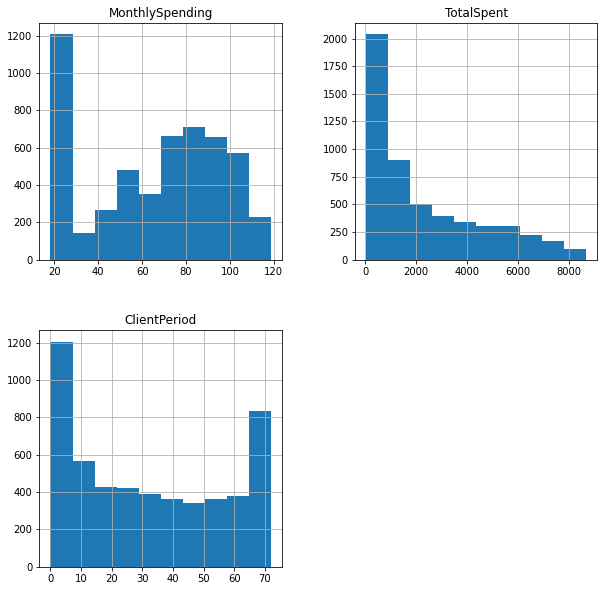

In [17]:
# построим гистограммы для численных признаков
df_train[number_columns].hist(figsize=(10, 10));

In [18]:
# посмотрим распределение
for i_col in binary_columns:
    print(f'{i_col}:\n{df_train[i_col].value_counts()}')
    print(20*'-')

Sex:
1    2655
0    2627
Name: Sex, dtype: int64
--------------------
IsSeniorCitizen:
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64
--------------------
HasPartner:
0    2705
1    2577
Name: HasPartner, dtype: int64
--------------------
HasChild:
0    3676
1    1606
Name: HasChild, dtype: int64
--------------------
HasPhoneService:
1    4761
0     521
Name: HasPhoneService, dtype: int64
--------------------
IsBillingPaperless:
0    3148
1    2134
Name: IsBillingPaperless, dtype: int64
--------------------


In [19]:
# посмотрим на описание данных
df_train.describe()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,Churn
count,5282.000000,5282.000000,5273.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2291.390461,0.502651,0.159409,0.487883,0.304051,0.901363,0.404014,0.262022
std,24.550326,30.176464,2269.014233,0.500040,0.366092,0.499900,0.460048,0.298202,0.490747,0.439776
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,35.462500,401.100000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,29.000000,70.400000,1410.250000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,55.000000,90.050000,3807.350000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Применение линейных моделей

In [20]:
# разделим данные на тренировочную и обучающие выборки
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('Churn', axis=1),
                                                         df_train['Churn'],
                                                         test_size=0.3,
                                                         stratify=df_train['Churn'],
                                                         random_state=123)

In [21]:
num_columns = binary_columns+number_columns
num_pipe = make_pipeline(SimpleImputer(), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder(sparse=True))
transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, category_columns)]
transformer = ColumnTransformer(transformers=transformers)
ml_pipe = make_pipeline(transformer, LogisticRegression(solver='liblinear',  random_state=123))

In [22]:
# выведем имена этапов
ml_pipe.steps

[('columntransformer',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('simpleimputer',
                                                    SimpleImputer()),
                                                   ('standardscaler',
                                                    StandardScaler())]),
                                   ['Sex', 'IsSeniorCitizen', 'HasPartner',
                                    'HasChild', 'HasPhoneService',
                                    'IsBillingPaperless', 'MonthlySpending',
                                    'TotalSpent', 'ClientPeriod']),
                                  ('cat',
                                   Pipeline(steps=[('onehotencoder',
                                                    OneHotEncoder())]),
                                   ['HasMultiplePhoneNumbers',
                                    'HasInternetService',
                                    'HasOnlineSecurityService

In [23]:
# задаем сетку гиперпараметров
param_grid = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median', 'constant'],
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__class_weight': ['balanced', None]
    }

In [24]:
# проведем поиск наилучших гиперпараметров
gs = GridSearchCV(ml_pipe, param_grid, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train);

In [25]:
print('Наилучшие значения гиперпараметров: {}'.format(gs.best_params_))
print('Наилучшее значение roc_auc: {:.3f}'.format(gs.best_score_))
print('Значение roc_auc на тренировочной выборке: {:.3f}'.format(gs.score(X_train, y_train)))
print('Значение roc_auc на тестовой выборке: {:.3f}'.format(gs.score(X_test, y_test)))

Наилучшие значения гиперпараметров: {'columntransformer__num__simpleimputer__strategy': 'constant', 'logisticregression__C': 1, 'logisticregression__class_weight': None}
Наилучшее значение roc_auc: 0.844
Значение roc_auc на тренировочной выборке: 0.849
Значение roc_auc на тестовой выборке: 0.847


### Применение градиентного бустинга

In [29]:
def objective_ctb(trial):
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop('Churn', axis=1).fillna(-9999),
                                                         df_train['Churn'],
                                                         test_size=0.2,
                                                         stratify=df_train['Churn'],
                                                         random_state=123)
    param_clf_ctb = {
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.5),
        'random_strength': trial.suggest_float('random_strength', 0.0, 0.3),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None'])}
    model_clf_ctb = CatBoostClassifier(
        cat_features=category_columns,
        learning_rate=0.015,
        iterations=300,
        eval_metric='AUC',
        random_seed=123,
        logging_level='Silent',
        depth=9)
    model_clf_ctb.set_params(**param_clf_ctb)
    model_clf_ctb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50)
    pred_proba = model_clf_ctb.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, pred_proba)

In [30]:
%%time
sampl = RandomSampler(seed=123)
study=optuna.create_study(sampler=sampl, direction='maximize')
study.optimize(objective_ctb, n_trials=20, n_jobs=-1, timeout=1200);

[I 2021-03-21 04:34:50,891] A new study created in memory with name: no-name-985a3d0b-80cb-4d4e-8c20-35cd66d6c95b
[I 2021-03-21 04:35:24,488] Trial 0 finished with value: 0.8511478293066741 and parameters: {'bagging_temperature': 1.0236654114319539, 'random_strength': 0.23848161683325347, 'l2_leaf_reg': 19, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8511478293066741.
[I 2021-03-21 04:35:24,707] Trial 1 finished with value: 0.8520873831343145 and parameters: {'bagging_temperature': 0.8023841866717214, 'random_strength': 0.27862160322895724, 'l2_leaf_reg': 15, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8520873831343145.
[I 2021-03-21 04:35:25,533] Trial 2 finished with value: 0.8506155697491437 and parameters: {'bagging_temperature': 0.24599505164497332, 'random_strength': 0.22700569206229518, 'l2_leaf_reg': 15, 'auto_class_weights': 'None'}. Best is trial 1 with value: 0.8520873831343145.
[I 2021-03-21 04:35:27,417] Trial 3 finished with value

CPU times: user 7min 28s, sys: 59.2 s, total: 8min 27s
Wall time: 2min 46s


In [31]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.853661020087013
  Params: 
    bagging_temperature: 0.08892961318234899
    random_strength: 0.12494631006738106
    l2_leaf_reg: 27
    auto_class_weights: Balanced


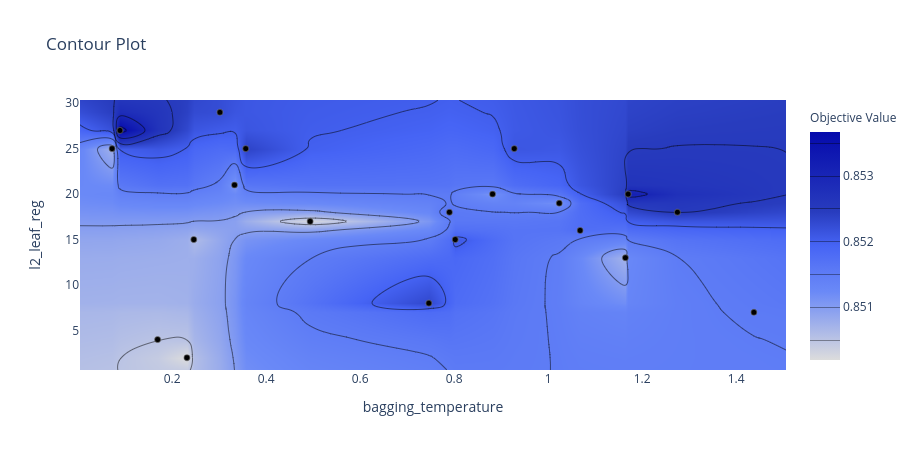

In [35]:
optuna.visualization.plot_contour(study, params=['l2_leaf_reg', 'bagging_temperature'])

#### Предсказания

In [39]:
train_pool = Pool(df_train.drop('Churn', axis=1).fillna(-9999),df_train['Churn'], cat_features=category_columns)
model_ctb = CatBoostClassifier(
    bagging_temperature=0.08892961318234899,
    l2_leaf_reg=27,
    random_strength=0.12494631006738106,
    auto_class_weights='Balanced',
    learning_rate=0.011,
    iterations=2000,
    random_seed=123,
    logging_level='Silent',
    depth=12)

In [40]:
model_ctb.fit(train_pool)

In [41]:
submission = pd.DataFrame()
submission['Churn'] = model_ctb.predict_proba(df_test)[:, 1]
submission.index.name = 'id'
submission.to_csv('submission_v4.csv')

In [42]:
!kaggle competitions submit -f submission_v4.csv advanced-dls-spring-2021 -m 'v4'

100%|██████████████████████████████████████| 41.4k/41.4k [00:06<00:00, 6.44kB/s]
Successfully submitted to Предсказание оттока пользователей (весна 2021)

In [43]:
!kaggle competitions submissions advanced-dls-spring-2021

fileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
submission_v4.csv  2021-03-21 01:48:51  v4           complete  0.83244      None          
submission_v3.csv  2021-03-17 00:19:37  v3           complete  0.84430      None          
submission_v2.csv  2021-03-15 23:39:33  v2           complete  0.84480      None          
submission_v1.csv  2021-03-15 23:39:13  v2           complete  0.82856      None          
submission_v1.csv  2021-03-15 23:01:43  v1           complete  0.82856      None          
